# Examine Results

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binom_test, chi2_contingency
import seaborn as sns

from convnwb.paths import Paths
from convnwb.io import get_files, load_json, load_jsons_to_df, load_matfile

from spiketools.plts.data import plot_hist, plot_bar
from spiketools.plts.utils import make_axes, save_figure
from spiketools.plts.annotate import add_hlines

In [2]:
import sys
sys.path.append('../code')
from plts import plot_stats_dots
from utils import corr_stats, print_corrs
from maps import LOC_MAP, SIDE_MAP

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
# Set pandas display options
pd.options.display.max_columns = None

## Settings

In [5]:
# Set which experiment version to run
experiment = 'THF'

In [6]:
# Define list of analyses
th_analyses = [#'allchest', 'fullchest', 'emptychest',
               'chest', 'place', 'target', 'serial']

# Collect names of analysis columns
th_analysis_columns = ['is_' + analysis for analysis in th_analyses]

In [7]:
# Set significance level
ALPHA_LEVEL = 0.05

In [8]:
# Set the folder to load results from
data_path = '../results/units/' + experiment

## Check Files

In [9]:
# Get the list of files
res_files = get_files(data_path, select='session')

In [10]:
# # Drop a specific set of files
# res_files = [file for file in res_files if 'wv003' not in file]

In [11]:
# # Select a specific set of files
# res_files = [file for file in res_files if 'wv001' in file]

In [12]:
# Check the number of available files
n_files = len(res_files)
n_files

643

## Load Example File

In [13]:
# Load an example file
file = res_files[0]
data = load_json(file, folder=str(data_path))

In [14]:
# # Check example file
# data

## Collect Results

In [15]:
# Collect all unit results together into a dataframe
all_results = load_jsons_to_df(res_files, folder=data_path)

In [16]:
# Check the columns
all_results.columns

Index(['uid', 'session_id', 'subject_id', 'wvID', 'keep', 'n_spikes',
       'firing_rate', 'presence_ratio', 'cluster', 'channel', 'location',
       'fr_t_val_all', 'fr_p_val_all', 'fr_t_val_empt', 'fr_p_val_empt',
       'fr_t_val_full', 'fr_p_val_full', 'place_anova', 'target_anova',
       'serial_anova', 'place_anova_surr_p_val', 'place_anova_surr_z_score',
       'target_anova_surr_p_val', 'target_anova_surr_z_score',
       'serial_anova_surr_p_val', 'serial_anova_surr_z_score'],
      dtype='object')

In [17]:
# Check the head of the results
all_results.head()

,uid,session_id,subject_id,wvID,keep,n_spikes,firing_rate,presence_ratio,cluster,channel,location,fr_t_val_all,fr_p_val_all,fr_t_val_empt,fr_p_val_empt,fr_t_val_full,fr_p_val_full,place_anova,target_anova,serial_anova,place_anova_surr_p_val,place_anova_surr_z_score,target_anova_surr_p_val,target_anova_surr_z_score,serial_anova_surr_p_val,serial_anova_surr_z_score
0,0,THF_wv001_session_0,wv001,1,True,630,0.511243,0.651822,2229,A10,LAH,0.838964,0.405121,-1.156732,0.261719,1.310645,0.198513,0.296563,1.591088,0.966072,0.989,-0.706820,0.145,0.926736,0.367,0.140749
1,1,THF_wv001_session_0,wv001,2,True,454,0.368420,0.676113,2360,A10,LAH,0.747516,0.457936,-1.071432,0.297397,2.223143,0.032760,1.295190,0.931677,1.034851,0.335,-0.059906,0.484,-0.198605,0.347,0.164065
2,2,THF_wv001_session_0,wv001,3,True,580,0.469046,0.797571,2421,A10,LAH,0.659236,0.512495,0.281954,0.781027,0.680864,0.500437,0.615918,0.810753,1.183255,0.775,-0.527601,0.510,-0.243767,0.203,0.666446
3,3,THF_wv001_session_0,wv001,4,True,2164,1.748777,1.000000,2556,A10,LAH,-0.051453,0.959151,1.046558,0.308436,-0.739510,0.464529,0.675223,2.017667,1.482066,0.743,-0.610637,0.060,1.581672,0.133,0.883660
4,4,THF_wv001_session_0,wv001,5,True,342,0.265360,0.526316,774,A15,LAH,-0.850696,0.398627,-0.842344,0.410074,-0.320374,0.750590,6.803619,0.974146,0.667268,0.014,1.232447,0.372,-0.016482,0.442,-0.160701


### Add binary labels for significance tests

In [18]:
# Add binary labels for statistical tests
#all_results['is_allchest'] = all_results['fr_p_val_all'] < ALPHA_LEVEL
all_results['is_chest'] = all_results['fr_p_val_full'] < ALPHA_LEVEL
#all_results['is_emptychest'] = all_results['fr_p_val_empt'] < ALPHA_LEVEL
all_results['is_place'] = all_results['place_anova_surr_p_val'] < ALPHA_LEVEL
all_results['is_target'] = all_results['target_anova_surr_p_val'] < ALPHA_LEVEL
all_results['is_serial'] = all_results['serial_anova_surr_p_val'] < ALPHA_LEVEL

### Unit Checks

In [19]:
# Firing rate threshold checks
print('# neurons fr < 0.15: \t', sum(all_results.firing_rate < 0.15))
#print('# neurons fr < 0.50: \t', sum(all_results.firing_rate < 0.50))

# neurons fr < 0.15: 	 35


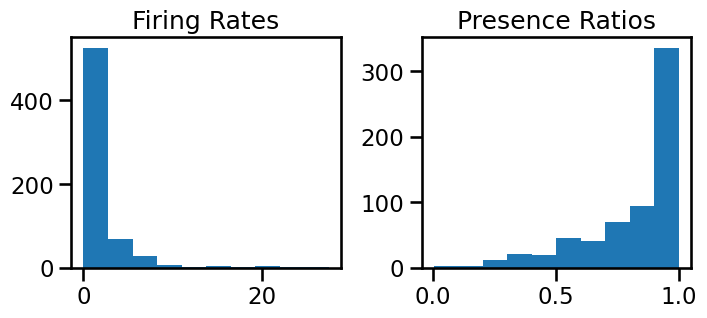

In [20]:
# Plot distribution of unit measures
axes = make_axes(2, 2, figsize=(8, 3), wspace=0.3)
plot_hist(all_results['firing_rate'].values, title='Firing Rates', ax=axes[0])
plot_hist(all_results['presence_ratio'].values, title='Presence Ratios', ax=axes[1])

In [21]:
# Check similarity of low firing rate & low presence ratio
low_frs = (all_results['firing_rate'] < 0.15).values
low_prs = (all_results['presence_ratio'] < 0.4).values
low_both = np.logical_and(low_frs, low_prs)

In [22]:
# Check the numbers of units for each measure
print('# low fr: \t{}'.format(sum(low_frs)))
print('# low pr: \t{}'.format(sum(low_prs)))
print('# low both: \t{}'.format(sum(low_both)))

# low fr: 	35
# low pr: 	38
# low both: 	31


In [23]:
# Add a marker for firing rate threshold in the TH experiment
all_results['keep_th'] = (all_results['firing_rate'] > 0.15).values

In [24]:
# Extract dropped neurons
dropped = all_results[~all_results['keep_th']]

In [25]:
# Check number of dropped neurons
n_dropped = len(dropped)
print('# of dropped units: \t{}'.format(n_dropped))

# of dropped units: 	35


In [26]:
print(experiment + ' - dropped:')
for analysis in th_analyses:
    temp = dropped[dropped['is_' + analysis]]
    print('{} ({} sig dropped): '.format(analysis, len(temp)))
    for _, row in temp.iterrows():
        print('\t' + row.session_id + '_U' + str(row.uid) + '  wvID:' + str(row.wvID))

THF - dropped:
chest (0 sig dropped): 
place (6 sig dropped): 
	THF_wv001_session_3_U9  wvID:191
	THF_wv001_session_3_U60  wvID:242
	THF_wv001_session_3_U67  wvID:249
	THF_wv001_session_4_U55  wvID:357
	THF_wv002_session_1_U63  wvID:559
	THF_wv004_session_1_U23  wvID:759
target (0 sig dropped): 
serial (4 sig dropped): 
	THF_wv001_session_3_U60  wvID:242
	THF_wv001_session_4_U55  wvID:357
	THF_wv004_session_1_U8  wvID:744
	THF_wv004_session_1_U72  wvID:808


In [27]:
# Sub-select main results file to keep neurons
all_results = all_results[all_results['keep_th']]

In [28]:
# Check number of neurons
n_units = len(all_results)
print('# neurons: ', n_units)

# neurons:  608


### Location Checks

In [29]:
# Set and collect which area each unit it is
all_results['region'] = all_results['location'].map(LOC_MAP)
all_results['side'] = all_results['location'].map(SIDE_MAP)

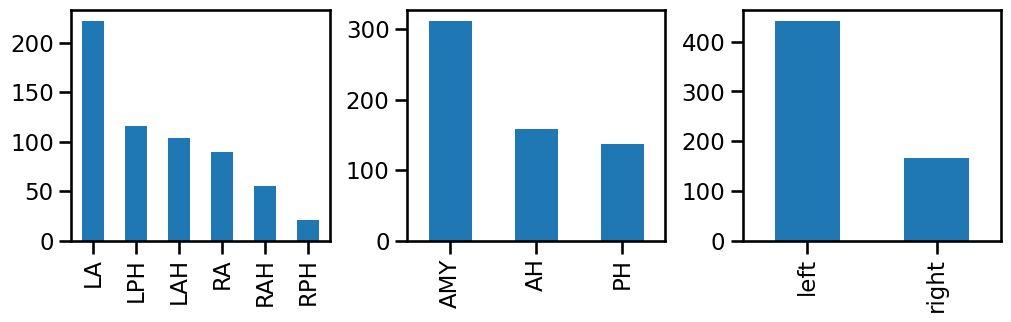

In [30]:
# Plot the unit counts per location
axes = make_axes(3, 3, figsize=(12, 3), wspace=0.3)
all_results['location'].value_counts().plot(kind='bar', ax=axes[0]);
all_results['region'].value_counts().plot(kind='bar', ax=axes[1]);
all_results['side'].value_counts().plot(kind='bar', ax=axes[2]);

In [31]:
# # Check location counts
# all_results['location'].value_counts()

In [32]:
# # Check area counts
# all_results['region'].value_counts()

In [33]:
# # Check area counts
# all_results['side'].value_counts()

## Check Results

In [34]:
# Get total number of units
n_units = len(all_results)
print('Total number of cells: {}'.format(n_units))

Total number of cells: 608


In [35]:
# Collect numbers of significant cells
results = {}
for analysis in th_analyses:
    results[analysis] = sum(all_results['is_' + analysis])

In [36]:
# Compute significance of the counts of detected neurons
stats = {}
for analysis in th_analyses:
    stats[analysis] = binom_test(results[analysis], n_units, ALPHA_LEVEL)

/home1/tom.donoghue/.conda/envs/thproj/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


In [37]:
# Check the number & percent of significant cells per analysis
print('{} - total cells: {}\n'.format(experiment, n_units))
for analysis in th_analyses:
    print('# {} cells:     \t\t{:3d}  ({:5.2f}%) \t\t {:.4f}'.format(\
        analysis, results[analysis], results[analysis] / n_units * 100, stats[analysis]))

THF - total cells: 608

# chest cells:     		108  (17.76%) 		 0.0000
# place cells:     		 28  ( 4.61%) 		 0.7797
# target cells:     		 43  ( 7.07%) 		 0.0249
# serial cells:     		 98  (16.12%) 		 0.0000


## Save out results

In [38]:
# Save out of CSV
#all_results.to_csv(experiment + '_all_results.csv')

#### Drop non-significant analyses

In [39]:
# ...
remove = ['place']
for el in remove:
    if el in th_analyses:
        th_analyses.remove(el)
    if 'is_' + el in th_analysis_columns:
        th_analysis_columns.remove('is_' + el)

## Check Results by Subject / Session

In [40]:
# Check the number of detected cells per subject
pd.pivot_table(all_results, th_analysis_columns, index='subject_id', aggfunc=np.sum)

,is_chest,is_serial,is_target
subject_id,,,
wv001,47,34,20
wv002,16,20,7
wv003,5,1,0
wv004,40,40,14
wv005,0,3,2


In [41]:
# Check the number of detected cells per session
pd.pivot_table(all_results, th_analysis_columns, index=['subject_id', 'session_id'], aggfunc=np.sum)

is_chest  is_serial  is_target
subject_id session_id                                         
wv001      THF_wv001_session_0        15          5         11
           THF_wv001_session_2        12          8          2
           THF_wv001_session_3        12          8          5
           THF_wv001_session_4         8         13          2
wv002      THF_wv002_session_0        13         13          3
           THF_wv002_session_1         3          7          4
wv003      THF_wv003_session_0         5          1          0
wv004      THF_wv004_session_0        26         16          5
           THF_wv004_session_1        14         24          9
wv005      THF_wv005_session_0         0          3          2

## Check Correlations

In [42]:
# Check correlation within / between real data measures and firing rate
cols = ['fr_t_val_full', 'fr_t_val_all', 'fr_t_val_empt',
        'target_anova', 'serial_anova', 'firing_rate']
extracted = all_results[cols]
extracted.corr()

,fr_t_val_full,fr_t_val_all,fr_t_val_empt,target_anova,serial_anova,firing_rate
fr_t_val_full,1.000000,0.871849,0.092676,-0.044892,-0.038910,-0.060964
fr_t_val_all,0.871849,1.000000,0.559811,-0.039314,-0.045466,-0.073624
fr_t_val_empt,0.092676,0.559811,1.000000,0.006989,-0.022113,-0.034960
target_anova,-0.044892,-0.039314,0.006989,1.000000,0.037750,-0.032141
serial_anova,-0.038910,-0.045466,-0.022113,0.037750,1.000000,0.148309
firing_rate,-0.060964,-0.073624,-0.034960,-0.032141,0.148309,1.000000


In [43]:
# Check correlation within / between surrogate data measures and firing rate
cols = ['target_anova_surr_z_score', 'target_anova_surr_p_val',
        'serial_anova_surr_z_score', 'serial_anova_surr_p_val', 
        'firing_rate']
extracted = all_results[cols]
extracted.corr()

,target_anova_surr_z_score,target_anova_surr_p_val,serial_anova_surr_z_score,serial_anova_surr_p_val,firing_rate
target_anova_surr_z_score,1.000000,-0.873316,0.024192,-0.049577,-0.010457
target_anova_surr_p_val,-0.873316,1.000000,-0.035312,0.059440,-0.002868
serial_anova_surr_z_score,0.024192,-0.035312,1.000000,-0.777513,0.175726
serial_anova_surr_p_val,-0.049577,0.059440,-0.777513,1.000000,-0.120390
firing_rate,-0.010457,-0.002868,0.175726,-0.120390,1.000000


## Results by Area

Analyze the results split up by area

Anatomical organization:
- 'region': a brain region, collapsing across left & right
- 'location': a specific location, split up by left & right

In [44]:
# Collect different area organizations together
places = {'region' : set(all_results['region']),
          'location' : set(all_results['location'])}

In [45]:
# Define which area organization to use
place = 'region'

In [46]:
# TEMP / HACK
nb_analyses = ['id', 'baseline']
# Add numbers of significant cells in 1B
for analysis in nb_analyses:
    results[analysis] = sum(all_results['is_' + analysis])

KeyError: 'is_id'

In [ ]:
#
region_results = {}
#for analysis in th_analyses:
for analysis in nb_analyses:

    region_results[analysis] = {}
    
    region_results[analysis]['all'] = {}
    region_results[analysis]['all']['count'] = results[analysis] 
    region_results[analysis]['all']['percent'] = results[analysis] / n_units

    for cplace in places[place]:
        temp = all_results[all_results[place] == cplace]
        
        region_results[analysis][cplace] = {}
        region_results[analysis][cplace]['count'] = sum(temp['is_' + analysis])
        region_results[analysis][cplace]['percent'] = sum(temp['is_' + analysis]) / len(temp)

In [ ]:
axes = make_axes(len(th_analyses), 3, hspace=0.35, figsize=(18, 5))
#for analysis, ax in zip(th_analyses, axes):
for analysis, ax in zip(nb_analyses, axes):
    labels = list(region_results[analysis].keys())
    values = [region_results[analysis][label]['percent'] for label in labels]
    plot_bar(values, labels, title=analysis, ylim=[0, 0.30], ax=ax)
    add_hlines(0.05, linestyle='--', color='black', ax=ax)

In [ ]:
region_counts = all_results['region'].value_counts().to_dict()
region_counts['all'] = n_units

In [ ]:
for canalysis, cregion_dict in region_results.items():
    for cregion, cdict in cregion_dict.items():
        region_results[canalysis][cregion]['p_value'] = \
            binom_test(cdict['count'], region_counts[cregion], ALPHA_LEVEL)

In [ ]:
print(experiment)
region_results

## Within Task Overlap

Compute the overlap of labels within TH task

In [47]:
# Compute overlap between labels within TH task
over = np.zeros([len(th_analysis_columns), len(th_analysis_columns)])
for i1, acol1 in enumerate(th_analysis_columns):
    a1res = set(all_results[all_results[acol1]].wvID.values)
    
    for i2, acol2 in enumerate(th_analysis_columns):
        a2res = set(all_results[all_results[acol2]].wvID.values)
        
        over[i1, i2] = len(a1res.intersection(a2res)) / len(a1res)

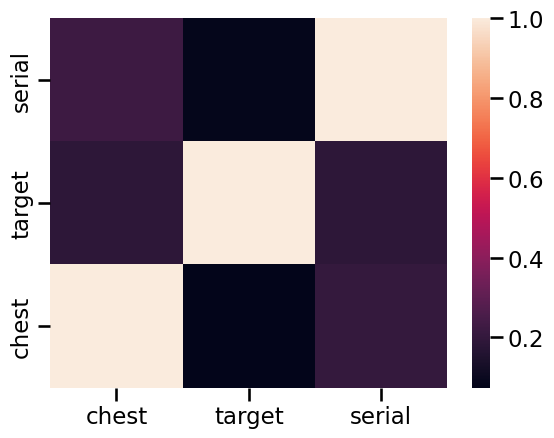

In [48]:
# Plot the overlap between TH labels
ax = sns.heatmap(over, xticklabels=th_analyses, yticklabels=th_analyses)
ax.invert_yaxis()

## Distributions

In [49]:
# Plot settings
bins = 35

### Chest Measures

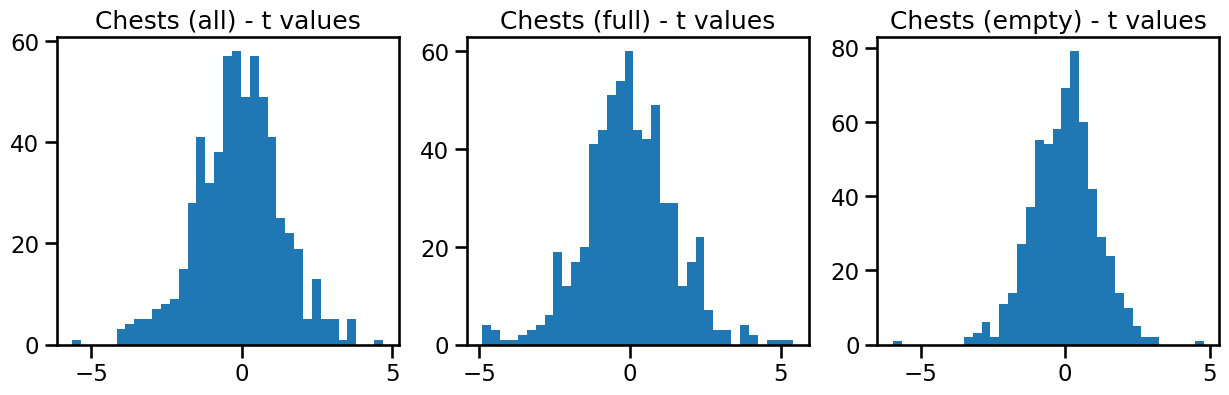

In [50]:
# Plot t-values of the chest measures
axes = make_axes(3, 3, figsize=(15, 4))
plot_hist(all_results.fr_t_val_all.values, title='Chests (all) - t values', bins=bins, ax=axes[0])
plot_hist(all_results.fr_t_val_full.values, title='Chests (full) - t values', bins=bins, ax=axes[1])
plot_hist(all_results.fr_t_val_empt.values, title='Chests (empty) - t values', bins=bins, ax=axes[2])

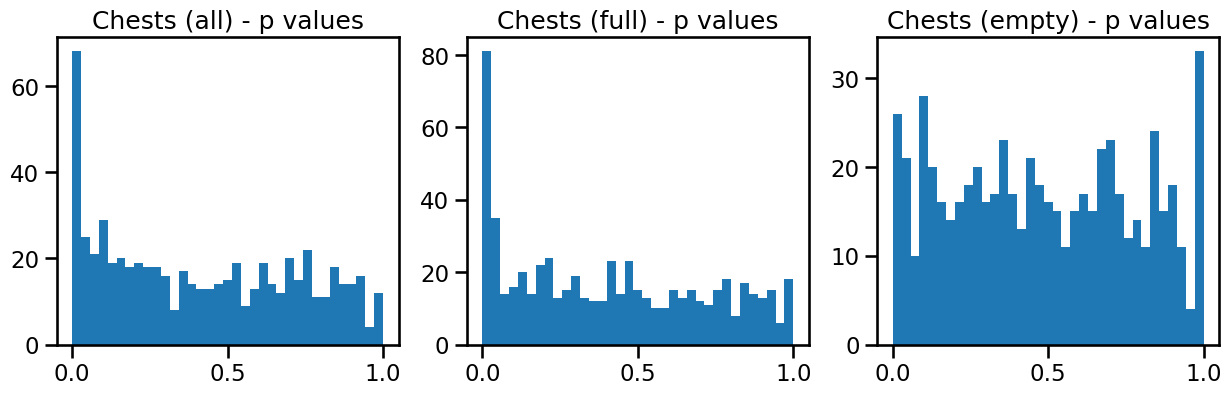

In [51]:
# Plot p-values of the chest measures
axes = make_axes(3, 3, figsize=(15, 4))
plot_hist(all_results.fr_p_val_all.values, title='Chests (all) - p values', bins=bins, ax=axes[0])
plot_hist(all_results.fr_p_val_full.values, title='Chests (full) - p values', bins=bins, ax=axes[1])
plot_hist(all_results.fr_p_val_empt.values, title='Chests (empty) - p values', bins=bins, ax=axes[2])

### Position & Sequence Measures

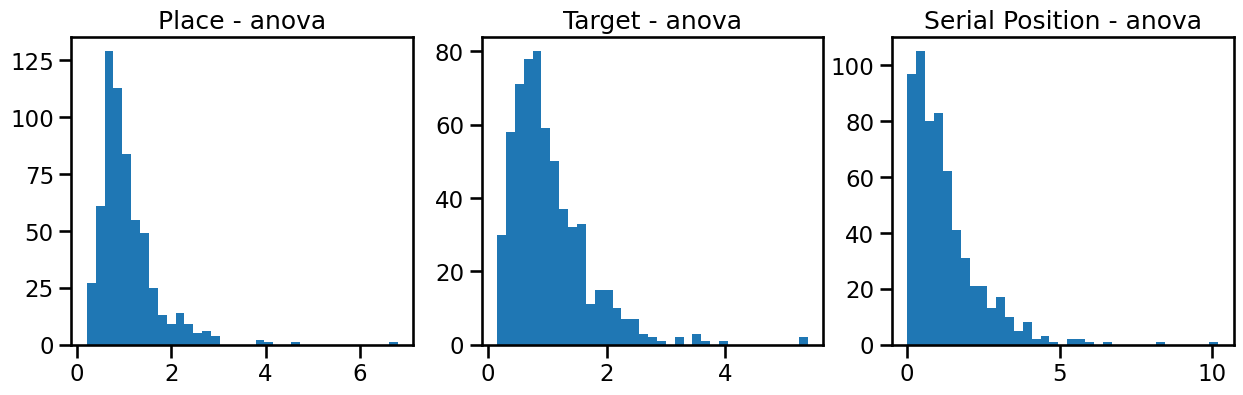

In [52]:
# Plot measure values of the position & sequence measures
axes = make_axes(3, 3, figsize=(15, 4), hspace=0.35)
plot_hist(all_results.place_anova.values, title='Place - anova', bins=bins, ax=axes[0])
plot_hist(all_results.target_anova.values, title='Target - anova', bins=bins, ax=axes[1])
plot_hist(all_results.serial_anova.values, title='Serial Position - anova', bins=bins, ax=axes[2])

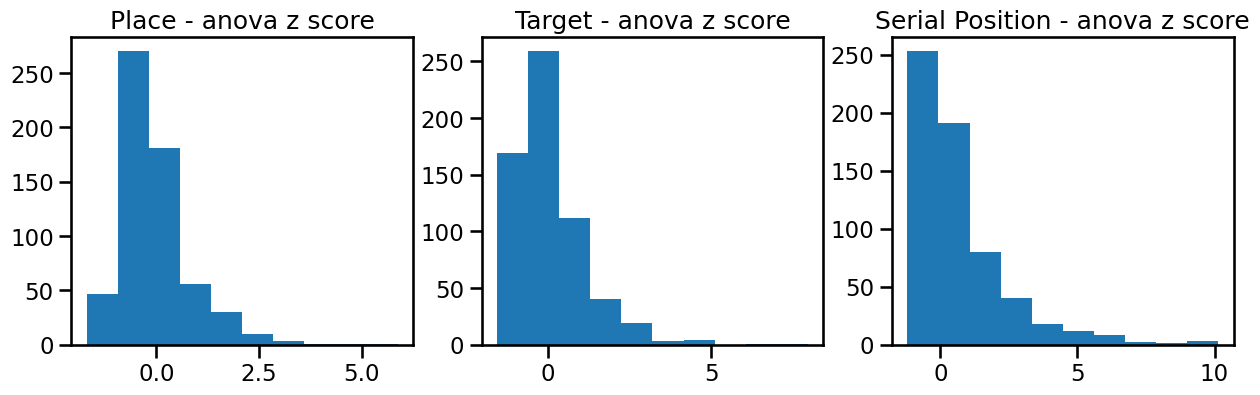

In [53]:
# Plot surrogate z-scores of the position & sequence measures
axes = make_axes(3, 3, figsize=(15, 4), hspace=0.35)
plot_hist(all_results.place_anova_surr_z_score.values, title='Place - anova z score', ax=axes[0])
plot_hist(all_results.target_anova_surr_z_score.values, title='Target - anova z score', ax=axes[1])
plot_hist(all_results.serial_anova_surr_z_score.values, title='Serial Position - anova z score', ax=axes[2])

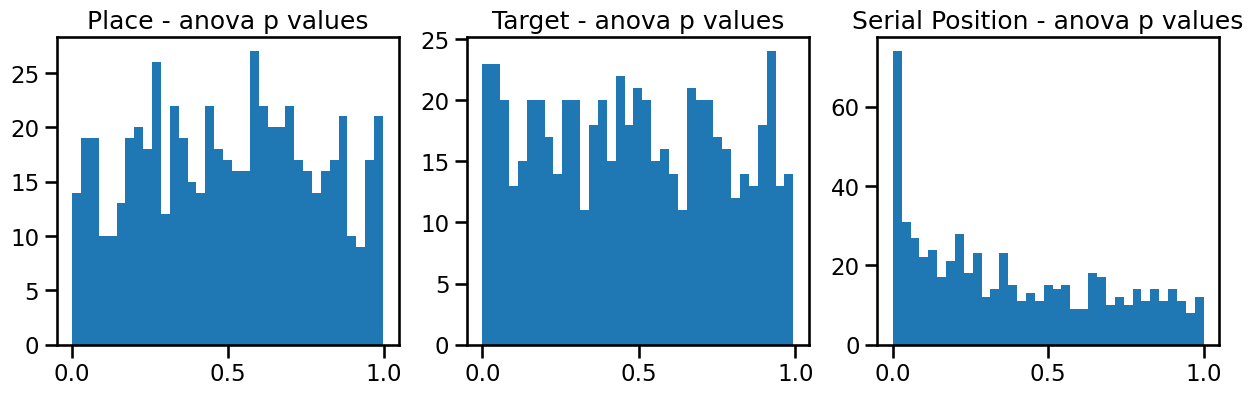

In [54]:
# Plot p values of the position & sequence measures
axes = make_axes(3, 3, figsize=(15, 4), hspace=0.35)
plot_hist(all_results.place_anova_surr_p_val.values, title='Place - anova p values', bins=bins, ax=axes[0])
plot_hist(all_results.target_anova_surr_p_val.values, title='Target - anova p values', bins=bins, ax=axes[1])
plot_hist(all_results.serial_anova_surr_p_val.values, title='Serial Position - anova p values', bins=bins, ax=axes[2])

## Task Overlap Analysis

In [55]:
# Define base project path
project_path = '/data12/jacobs_lab/WVTH/'

In [56]:
# Create paths object
paths = Paths(project_path)

### Identity Neuron

Identity neuron fields:
- ID_neuron: identity neuron
- MI_neuron: multiple identity neuron
- SI_neuron: single identity neuron

In [57]:
# Define the file path for the relevant nback results file
if experiment == 'THF':
    id_file_name = 'ID neuron CelebA_NavSelect MeanResponse 2SD.mat'
if experiment == 'THO':
    id_file_name = 'ID neuron ImageNet_NavSelect MeanResponse 2SD.mat'

In [58]:
# Load nback results data
nback_data = load_matfile(id_file_name, folder=paths.info / 'nback', squeeze_me=True)

In [59]:
# Check the available keys in the loaded nback data
f_dunders = [key for key in nback_data.keys() if key[0] == '_']
keys = [key for key in nback_data.keys() if key[0] != '_']
keys

['CodeID', 'CodeIDNum', 'ID_neuron', 'MI_neuron', 'SI_neuron', 'selMethod']

In [60]:
# Drop some data that we are not using here
for field in ['CodeID', 'selMethod', 'CodeIDNum', *f_dunders]:
    nback_data.pop(field, None)

### Baseline firing

In [61]:
# Define the file path for the relevant nback results file
if experiment == 'THF':
    file_name = 'SortedFRCelebA_Nav.mat'
if experiment == 'THO':
    file_name = 'SortedFRImageNet_Nav.mat'

In [62]:
# Load the data file
fr_data = load_matfile(file_name, folder=paths.info / 'nback', squeeze_me=True)

In [63]:
# Check the available keys in the metadata file
print([el for el in fr_data.keys() if el[0] != '_'])

['sessions', 'timestampsOfCellAll', 'vCell', 'areaCell', 'vCh', 'vClusterID', 'vWire', 'periodsAll', 'binW', 'binStep', 'FR', 'beh', 'FR_sort', 'vReject', 'vKeep', 'pBase', 'pAnova', 'vAnova', 'vBase']


In [64]:
# Add the baseline response firing analysis to collection of analyses
nback_data['vBase'] = fr_data['vBase']

#### Drop Cells Dropped in TH

In [65]:
# Drop any cell IDs that were excluded from TH
print('Dropped in 1B by TH:')
for analysis in nback_data.keys():
    n_dropped_1b = len(set(nback_data[analysis]) & set(dropped.wvID.values))
    nback_data[analysis] = np.array(list(set(nback_data[analysis]) - set(dropped.wvID.values)))
    print('\t{:10s}: \t{}'.format(analysis, n_dropped_1b))

Dropped in 1B by TH:
	ID_neuron : 	2
	MI_neuron : 	1
	SI_neuron : 	1
	vBase     : 	4


#### Overlap Within nBack

In [66]:
# Define list of nback analyses
nback_analyses = ['ID_neuron', 'MI_neuron', 'SI_neuron', 'vBase']

In [67]:
# Compute overlap between labels within nBack task
over = np.zeros([len(nback_analyses), len(nback_analyses)])
for i1, acol1 in enumerate(nback_analyses):
    a1res = set(nback_data[acol1])
    
    for i2, acol2 in enumerate(nback_analyses):
        a2res = set(nback_data[acol2])
        
        over[i1, i2] = len(a1res.intersection(a2res)) / len(a1res)

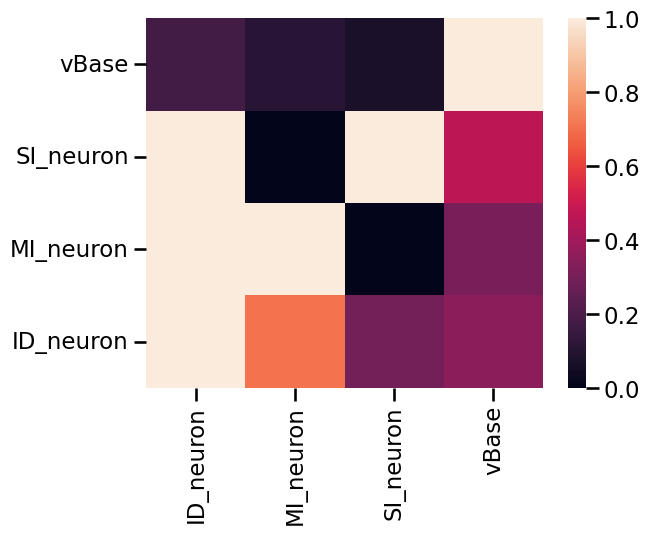

In [68]:
# Plot the overlap between nBack labels
ax = sns.heatmap(over, xticklabels=nback_analyses, yticklabels=nback_analyses)
ax.invert_yaxis()

# Compute Between Task Overlap

In [69]:
# Set which nBack analysis to compare to
nb_analysis = 'base'  # 'base', 'ID'

In [70]:
if nb_analysis == 'ID':
    nb_data = nback_data['ID_neuron']
if nb_analysis == 'base':
    nb_data = nback_data['vBase']

In [71]:
print(experiment, ' - ', nb_analysis, '\n')
print('\t {} \t {} \t {} \t {} \t\t {} \t\t{}'.format('#NB', '#TH', '#Over', '%Over', 'pval', 'exp'))
for analysis in th_analyses:

    th_data = all_results[all_results['is_' + analysis]].wvID.values
    n_th = len(th_data)

    n_nb = len(nb_data)
    
    inter = len(set(th_data).intersection(set(nb_data)))
    
    arr = np.array([[inter, n_th-inter],
                    [n_nb-inter, n_units-n_th-n_nb+inter]])
    tstat, pval, dof, exp = chi2_contingency(arr, False)

    print('{} \t {} \t {} \t {} \t {:5.2f}% \t {:5.4f} \t {:2d}'.format(\
        analysis, n_nb, n_th, inter, (inter / n_nb) * 100, pval, round(exp[0][0])))

THF  -  base 

	 #NB 	 #TH 	 #Over 	 %Over 		 pval 		exp
chest 	 102 	 108 	 31 	 30.39% 	 0.0003 	 18
target 	 102 	 43 	 7 	  6.86% 	 0.9279 	  7
serial 	 102 	 98 	 18 	 17.65% 	 0.6453 	 16


## Combine Between Tasks

In [72]:
# Check that all the IDs line up
for nb_analysis in ['ID_neuron', 'vBase']:
    for wvid in nback_data[nb_analysis]:
        if wvid not in all_results.wvID.values:
            assert wvid in all_results.wvID.values

In [73]:
#all_results

In [74]:
# # Add columns to overall dataframe for nback task labels
# all_results['is_ID_cell'] = False
# all_results['is_baseline_cell'] = False

In [75]:
# # Add in results from nback analyses listing which cells are nback task active cells
# for wvid in all_results.wvID.values:
#     if wvid in nback_data['ID_neuron']:
#         all_results.loc[all_results[all_results.wvID == wvid].index[0], 'is_ID_cell'] = True
#     if wvid in nback_data['vBase']:
#         all_results.loc[all_results[all_results.wvID == wvid].index[0], 'is_baseline_cell'] = True

In [76]:
# # Check that the alignment worked
# assert set(nback_data['vBase']) == set(all_results[all_results.is_baseline_cell].wvID.values)
# assert set(nback_data['ID_neuron']) == set(all_results[all_results.is_ID_cell].wvID.values)

#### Check the distribution of cells in nBack

In [77]:
# # Define nback label columns to add
# nback_analysis_columns = ['is_ID_cell', 'is_baseline_cell']

In [78]:
# # Check the number of detected cells per session
# pd.pivot_table(all_results, nback_analysis_columns, index=['subject_id', 'session_id'], aggfunc=np.sum)

In [79]:
# # Save out the combined results file
# all_results.to_csv(experiment + '_combined_all_results.csv')

## Overlap Stats

In [80]:
# Define the file path for the relevant nback results file
if experiment == 'THF':
    stats_filename = 'vID_vBase_Selection_CelebA_Nav.csv'
if experiment == 'THO':
    stats_filename = 'vID_vBase_Selection_ImageNet_Nav.csv'

In [81]:
# Load n-back stats
nback_stats = pd.read_csv(paths.info / 'nback' / stats_filename)

In [82]:
# Rename the CellIndex column -> WvID
new_names = {'CellIndex' : 'wvID', 'Fvalue-anova' : 'id_fvalue', 'TValue-baseline' : 'baseline_tvalue', 
             'IDNeuron' : 'is_id', 'vBaseline' : 'is_baseline'}
nback_stats.rename(columns=new_names, inplace=True)

In [83]:
# Sub-select only stats columns
nback_stats = nback_stats[['wvID', 'id_fvalue', 'baseline_tvalue', 'is_id', 'is_baseline']]

In [84]:
# Create merged df
all_results = all_results.merge(nback_stats)

In [85]:
# Create absolute value'd version of t-distributions
all_results['baseline_tvalue_abs'] = np.abs(all_results['baseline_tvalue'])
all_results['fr_t_val_full_abs'] = np.abs(all_results['fr_t_val_full'])

In [86]:
# assert np.all(all_results['is_id'] == all_results['is_ID_cell'])
# assert np.all(all_results['is_baseline'] == all_results['is_baseline_cell'])

## Full Group Comparisons

Compare stat values across all neurons.

In [87]:
SAVE_FIG = False

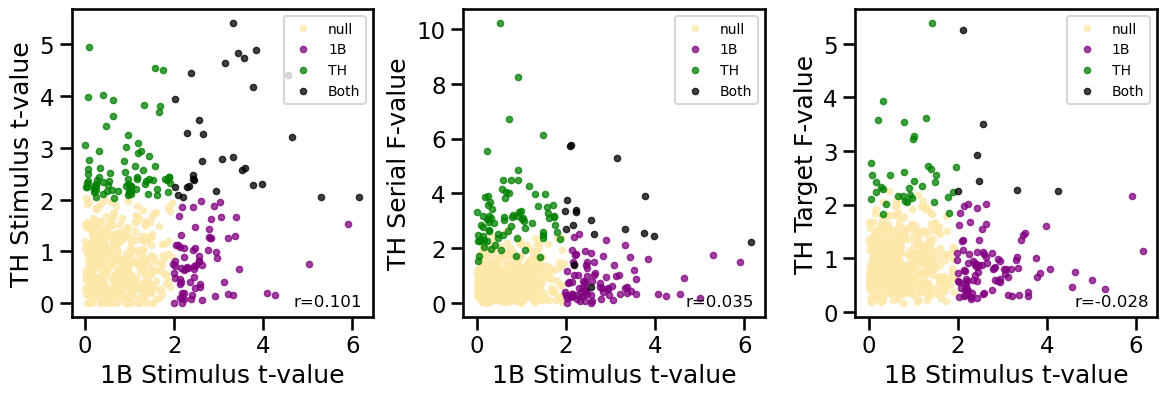

In [88]:
axes = make_axes(3, 3, wspace=0.3, figsize=(14, 4))
plot_stats_dots(all_results, 'nback_stimulus', 'th_stimulus', ax=axes[0])
plot_stats_dots(all_results, 'nback_stimulus', 'th_serial', ax=axes[1])
plot_stats_dots(all_results, 'nback_stimulus', 'th_target', ax=axes[2])
if SAVE_FIG: save_figure(experiment + '_stim_stats.pdf', bbox_inches='tight')

In [89]:
print_corrs(corr_stats(all_results, 'nback_stimulus', 'th_stimulus'), 'Stimulus / Stimulus')
print_corrs(corr_stats(all_results, 'nback_stimulus', 'th_serial'), 'Stimulus / Serial')
print_corrs(corr_stats(all_results, 'nback_stimulus', 'th_target'), 'Stimulus / Serial')

Stimulus / Stimulus
	 all 	- r = +0.10 	 p = 0.01
	 null 	- r = -0.04 	 p = 0.46
	 NB 	- r = +0.19 	 p = 0.11
	 TH 	- r = +0.07 	 p = 0.57
	 both 	- r = +0.16 	 p = 0.38
Stimulus / Serial
	 all 	- r = +0.03 	 p = 0.39
	 null 	- r = +0.11 	 p = 0.02
	 NB 	- r = +0.08 	 p = 0.48
	 TH 	- r = +0.22 	 p = 0.05
	 both 	- r = -0.36 	 p = 0.14
Stimulus / Serial
	 all 	- r = -0.03 	 p = 0.50
	 null 	- r = -0.01 	 p = 0.80
	 NB 	- r = +0.04 	 p = 0.74
	 TH 	- r = +0.04 	 p = 0.83
	 both 	- r = -0.14 	 p = 0.76


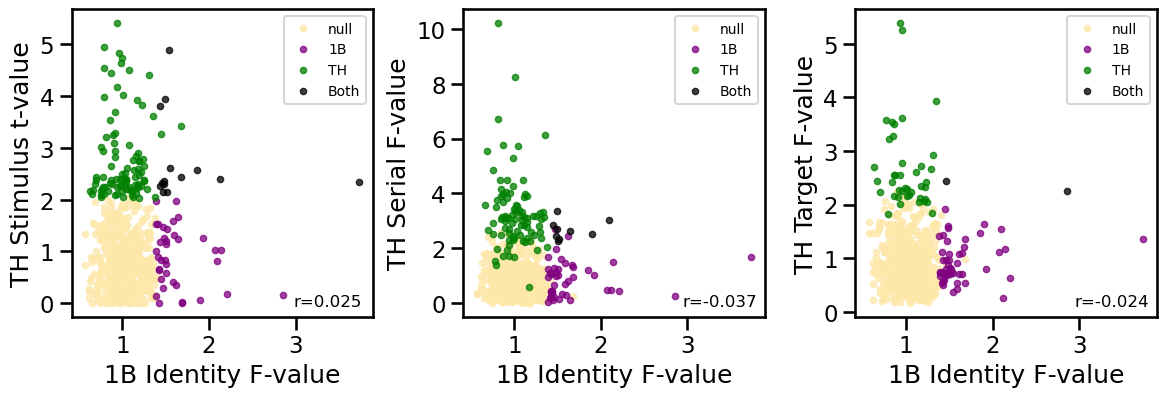

In [90]:
axes = make_axes(3, 3, wspace=0.3, figsize=(14, 4))
plot_stats_dots(all_results, 'nback_id', 'th_stimulus', ax=axes[0])
plot_stats_dots(all_results, 'nback_id', 'th_serial', ax=axes[1])
plot_stats_dots(all_results, 'nback_id', 'th_target', ax=axes[2])
if experiment == 'THO':
    for ax in axes: ax.set_xlim([-0.2, 6])
save_figure(experiment + '_id_stats.pdf', bbox_inches='tight')

In [91]:
print_corrs(corr_stats(all_results, 'nback_id', 'th_stimulus'), 'Stimulus / Stimulus')
print_corrs(corr_stats(all_results, 'nback_id', 'th_serial'), 'Stimulus / Serial')
print_corrs(corr_stats(all_results, 'nback_id', 'th_target'), 'Stimulus / Serial')

Stimulus / Stimulus
	 all 	- r = +0.03 	 p = 0.54
	 null 	- r = -0.03 	 p = 0.58
	 NB 	- r = -0.15 	 p = 0.37
	 TH 	- r = +0.07 	 p = 0.48
	 both 	- r = +0.24 	 p = 0.41
Stimulus / Serial
	 all 	- r = -0.04 	 p = 0.37
	 null 	- r = -0.07 	 p = 0.14
	 NB 	- r = +0.16 	 p = 0.31
	 TH 	- r = -0.16 	 p = 0.13
	 both 	- r = -0.03 	 p = 0.93
Stimulus / Serial
	 all 	- r = -0.02 	 p = 0.55
	 null 	- r = -0.03 	 p = 0.52
	 NB 	- r = +0.11 	 p = 0.46
	 TH 	- r = -0.21 	 p = 0.18
	 both 	- r = -1.00 	 p = nan


## XX

In [92]:
experiment

'THF'

In [93]:
raise ValueError

ValueError: 

In [ ]:
#all_results_tho = all_results
all_results_thf = all_results

In [ ]:
# # Save out of CSV
# all_results_tho.to_csv('tho_all_results.csv')
# all_results_thf.to_csv('thf_all_results.csv')

In [ ]:
SAVE_FIG = False

In [ ]:
xlim = [-0.1, 7.1]
ylim1 = [-0.1, 7.5]
ylim2 = [-0.1, 11]

In [ ]:
axes = make_axes(4, 4, wspace=0.3, figsize=(18, 4))
plot_stats_dots(all_results_thf, 'nback_stimulus', 'th_stimulus', 
                title='Face: Stimulus-Stimulus', xlim=xlim, ylim=ylim1, ax=axes[0])
plot_stats_dots(all_results_tho, 'nback_stimulus', 'th_stimulus',
                title='Object: Stimulus-Stimulus', xlim=xlim, ylim=ylim1, ax=axes[1])
plot_stats_dots(all_results_thf, 'nback_stimulus', 'th_serial',
                title='Face: Stimulus-Serial', xlim=xlim, ylim=ylim2, ax=axes[2])
plot_stats_dots(all_results_tho, 'nback_stimulus', 'th_serial',
                title='Object: Stimulus-Serial', xlim=xlim, ylim=ylim2, ax=axes[3])
if SAVE_FIG:
    save_figure('group_stats.svg', bbox_inches='tight')